# Implementing all models 


In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

In [2]:
df = pd.read_csv("NAS.csv")                         #Read the csv
df.iloc[:, 0]= pd.to_datetime(df.iloc[:, 0])        #Convert date to datetime  
df.set_index('Date',inplace=True)                   #Setting date as index

In [3]:
df.replace(0, np.nan, inplace=True) #Replacing 0 with NaN
df.dropna(inplace=True)  #Dropping all columns with NaN

In [4]:
#plot all days from -1 to 1 in relation to how many days have passed since the first day in the data frame
df['days_from_start'] = (df.index - df.index[0]).days
X = df['days_from_start'].values.reshape(-1, 1)
y = df['Close'].values

In [5]:
#converts any inserted date into a number relative to the index of the first data point 
def convertDate(date):                               #insert date as 'YYYY-MM-DD'
    date = pd.Timestamp(date)
    return (date - df.index[0]).days

#example:
#print(convertDate('2020-10-24'))

In [6]:
def fetchToday():                                    #fetch today's date
    return pd.Timestamp.today().floor('D').date()

In [7]:
#Creating a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
# standardizing data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test=scaler.transform(X_test)

Here we trained and tested different algorithms (Linear Regression, SGD and Decision Tree Regression) to establish which had better results.

In [9]:
#Training the 3 models

#Linear Regression
regressor = LinearRegression()
regressor.fit(X_train, y_train)  #Fits it with a linar regression

#SGD Regression
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

#Decision Tree Regression
DTreeModel = DecisionTreeRegressor(max_depth=500)
DTreeModel.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=500)

In [10]:
#test all 3 models
LR_pred = regressor.predict(X_test)
SGD_pred = sgd.predict(X_test)
Dtree_pred = DTreeModel.predict(X_test)

## Testing Prediction Percentage Score

In [11]:
#gives out information about each model
def ModelScoring(name, model): #pass the name of the model, and the model itself
    print(name)
    print('Mean Squared Error :',metrics.mean_squared_error(y_test, model.predict(X_test)))
    print('Mean Absolute Error :',metrics.mean_absolute_error(y_test, model.predict(X_test)))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, model.predict(X_test))))
    print("Score:", model.score(X_test, y_test))
    print()

In [12]:
ModelScoring("SGD Regressor", sgd)
ModelScoring("Linear Regressor", regressor)
ModelScoring("Decision Tree Regressor", DTreeModel)

SGD Regressor
Mean Squared Error : 2321.413577920632
Mean Absolute Error : 36.45153138507536
Root Mean Squared Error: 48.181049987735136
Score: 0.2049246536324012

Linear Regressor
Mean Squared Error : 2325.7962434978367
Mean Absolute Error : 36.420276591070795
Root Mean Squared Error: 48.22650975861551
Score: 0.20342360729367415

Decision Tree Regressor
Mean Squared Error : 10.493652677901277
Mean Absolute Error : 1.7428265648038046
Root Mean Squared Error: 3.239390788080573
Score: 0.9964059637554903



Here we see that the Decision Tree Regressor has the highest score by far.
We therefore chose it as the algorithm for the rest of the assignment.

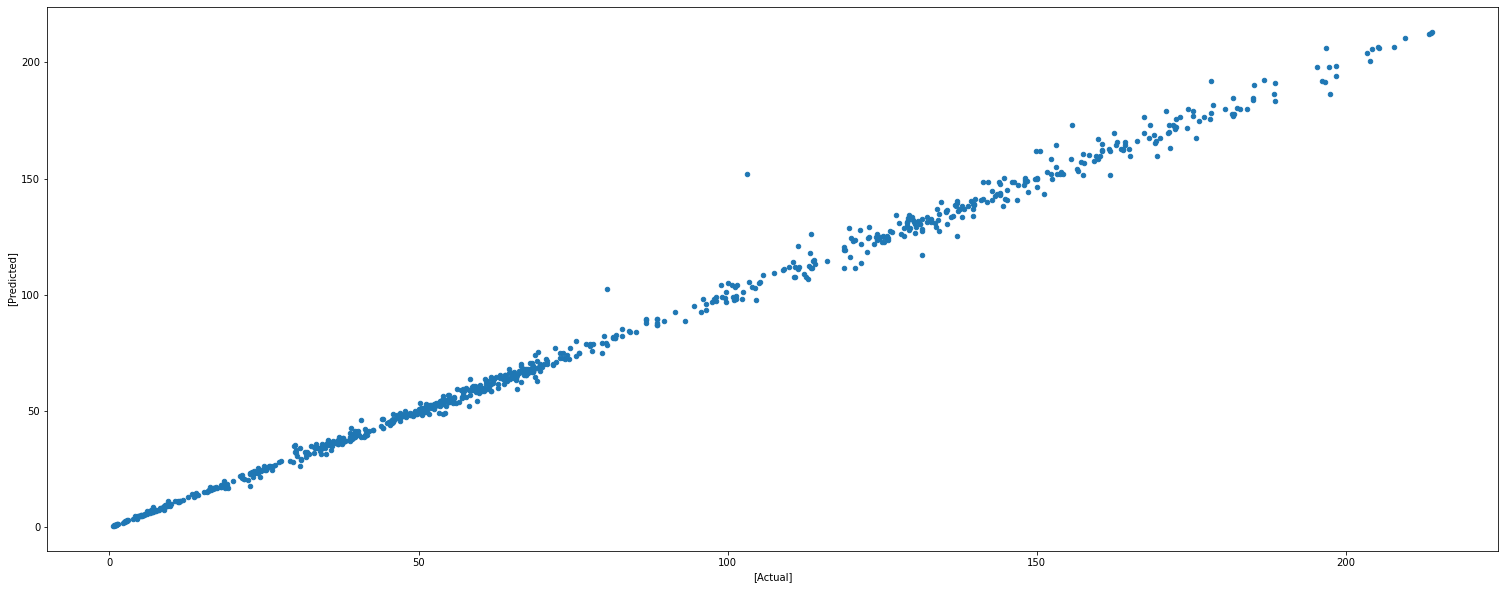

In [24]:
#Mapping to plot
df2 = pd.DataFrame({'Actual': y_test, 'Predicted': Dtree_pred})
df2.plot.scatter(['Actual'],['Predicted'],figsize=(26,10))

## Predict todays closing price by giving todays opening price

In [15]:
#normalizes date that is inserted so that it fits into the -1 to 1 scale
def normalizeData(date):
    outDate=pd.DataFrame([[date]])
    outDate=scaler.transform(outDate)
    return outDate

In [16]:
#predicts the price according to the selected algorithm 
#(allows for selection; purposeful decision to allow method to be generic)
def predictPrice(date, algorithm):
    date=normalizeData(date)
    prediction = algorithm.predict(date)
    return prediction

In [17]:
#calculates the difference between the result(s) of the selected model(s) and the real closing price 
def assessDifference(date, *argv, closing): #The args are the prediction algorithms you want to test on   
    i=0
    predList = []
    for model in argv:
        prediction = predictPrice(date, model)
        print("Model " +str(model) + ": ")
        print(f'The predicted closing value is {str(float(prediction))} NOK')
        print
        predList.append(prediction)
        print(f'The prediction is off by {float(closing-prediction)} NOK')
        print(f'The prediction is off by {float((closing-prediction)*100/closing)}%')
        i+=1
    
    #if testing multiple models
    if i>1:
        print(f'The mean of the models is {float(findMean(predList))} NOK')
        print(f'The mean of the models is off by {findMeanDifference(closing, predList)} NOK')
        print(f'The mean of the models is off by {float((closing-findMeanDifference(closing, predList))*100/closing)}%')       

In [18]:
def findMean(predictionList):
    return sum(predictionList)/len(predictionList)

In [19]:
def findMeanDifference(closing, predictionList):
    return float(closing-findMean(predictionList))

In [20]:
#demonstrates assessDifference for a date where data is available
assessDifference(convertDate('2020-02-20'), DTreeModel, closing=36.9200)

Model DecisionTreeRegressor(max_depth=500): 
The predicted closing value is 36.049999 NOK
The prediction is off by 0.870001000000002 NOK
The prediction is off by 2.3564490790899297%


In [22]:
def predictedAndReal(date):
    predict = predictPrice(convertDate(date), DTreeModel)
    print(f'The predicted price on {date} is {float(predict)} NOK')
    try:
        result = df.loc[date]
        print(f'The real price on {date} was {float(result["Close"])} NOK')
    except KeyError:
        print(f"The dataset doesn't have data for {date}")
    except:
        pass

## Find today's prediction

In [23]:
predictedAndReal(fetchToday())

The predicted price on 2020-10-25 is 0.605 NOK
The dataset doesn't have data for 2020-10-25
